In [33]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Phân lớp _ XG Boost 
Huấn luyện riêng lẻ từng cổ phiếu 

Bắt đầu huấn luyện riêng lẻ cho 5 mã cổ phiếu...

--- Đang xử lý mã: FPT ---

--- Đang xử lý mã: HPG ---

--- Đang xử lý mã: KDH ---

--- Đang xử lý mã: PNJ ---

--- Đang xử lý mã: VCB ---

--- BÁO CÁO KẾT QUẢ TỪNG MÔ HÌNH ---

======== FPT ========
  Accuracy:          0.5266
  --- Lớp TĂNG (1) --- Precision: 0.5970 | Recall: 0.1835
  --- Lớp GIẢM (0) --- Precision: 0.5137 | Recall: 0.8744

======== HPG ========
  Accuracy:          0.5242
  --- Lớp TĂNG (1) --- Precision: 0.4602 | Recall: 0.2640
  --- Lớp GIẢM (0) --- Precision: 0.5469 | Recall: 0.7415

======== KDH ========
  Accuracy:          0.4688
  --- Lớp TĂNG (1) --- Precision: 0.4522 | Recall: 0.7919
  --- Lớp GIẢM (0) --- Precision: 0.5341 | Recall: 0.1992

======== PNJ ========
  Accuracy:          0.5427
  --- Lớp TĂNG (1) --- Precision: 0.5652 | Recall: 0.1884
  --- Lớp GIẢM (0) --- Precision: 0.5385 | Recall: 0.8673

======== VCB ========
  Accuracy:          0.5242
  --- Lớp TĂNG (1) --- Precision: 0.4275 | Recall: 0.3

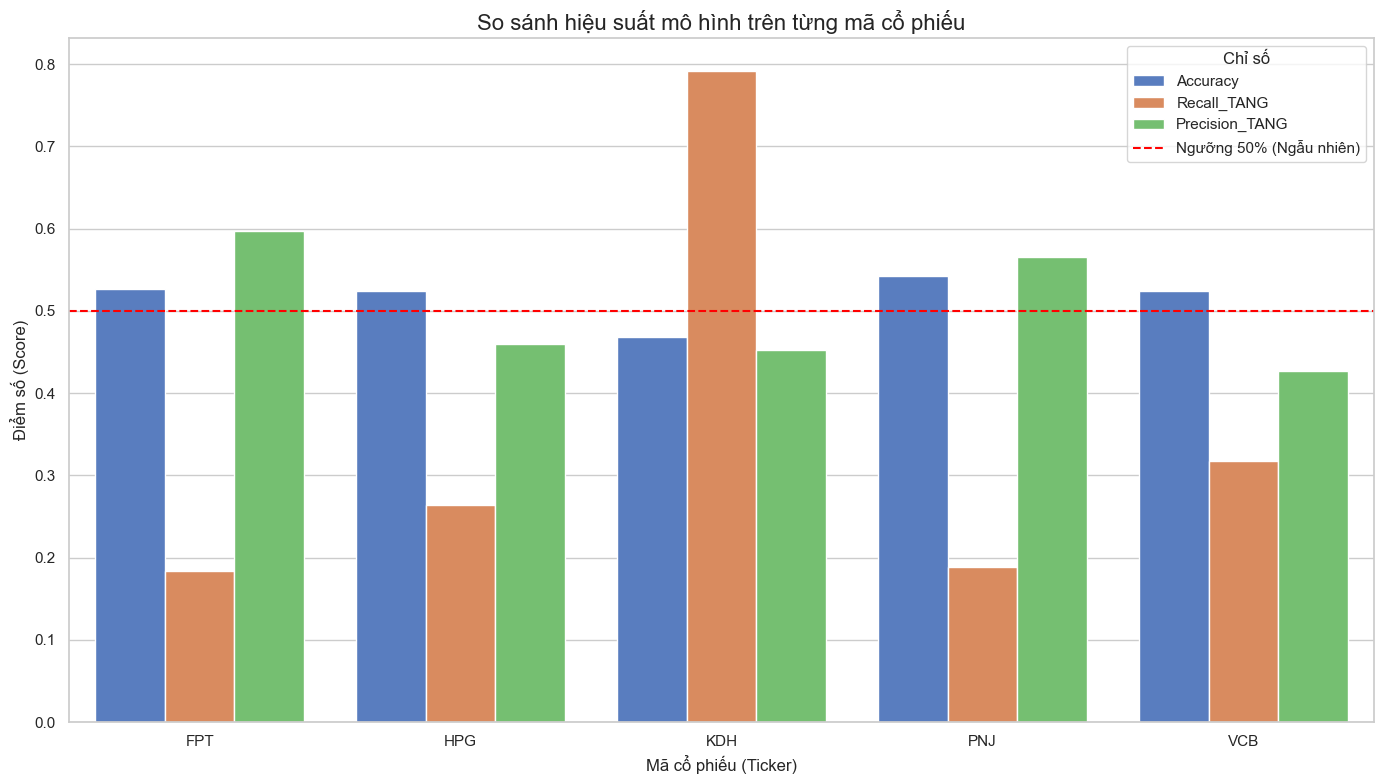


--- Đang vẽ biểu đồ Precision & Recall cho từng lớp ---
ĐÃ LƯU: precision_recall_difference.png


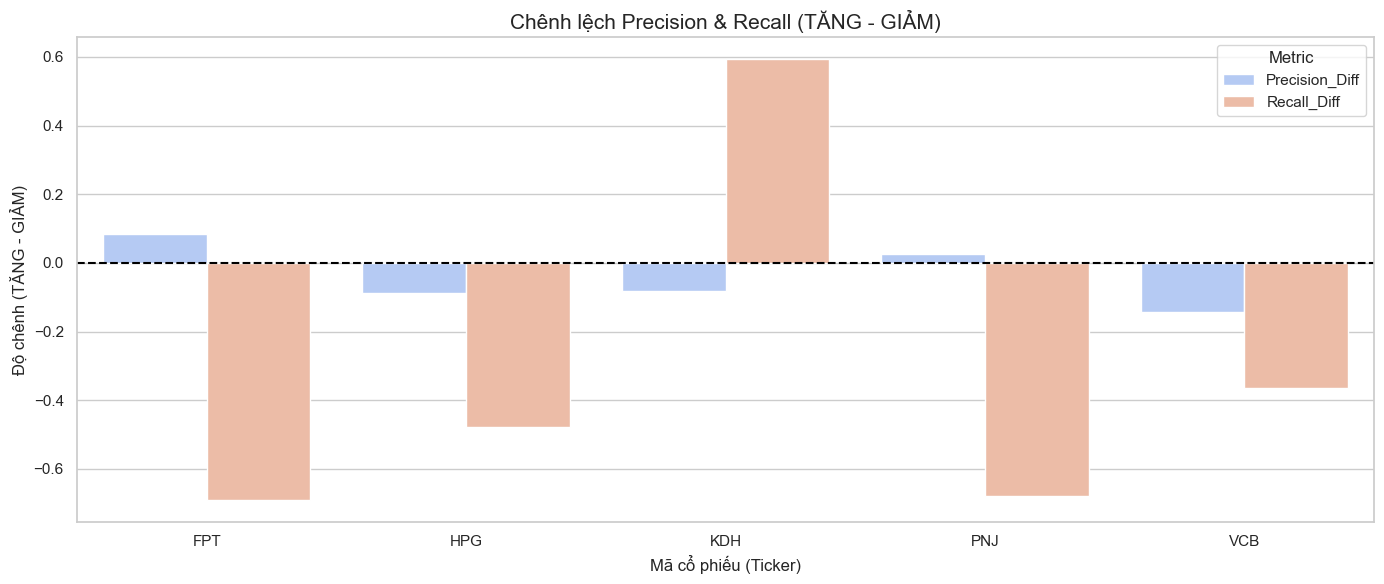


--- Đang vẽ Heatmap tổng quan Precision/Recall ---
ĐÃ LƯU: precision_recall_heatmap.png


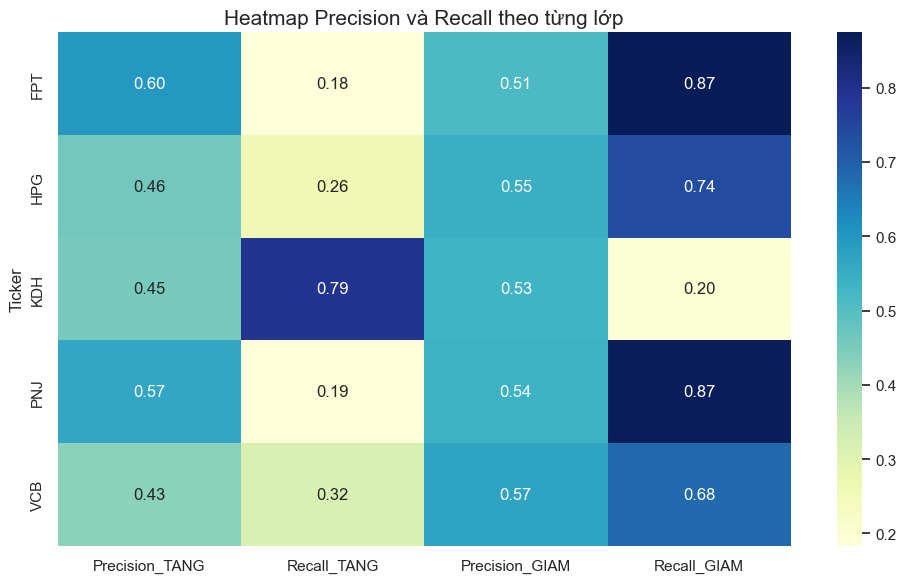


 TẤT CẢ 10 FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'huanluyenriengle'

--- TỔNG THỜI GIAN CHẠY: 0.31 phút ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import time
import os
import shutil 

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# 1: CÔNG CỤ LẤY METRIC AN TOÀN 
def safe_get(report_dict, label, metric):
    """ Khi lấy kết quả precision hoặc recall từ báo cáo, nếu vì lý do nào đó lớp TĂNG hoặc GIẢM không có mẫu nào, 
    hàm này sẽ trả về 0.0 thay vì gây lỗi """
    return float(report_dict.get(label, {}).get(metric, 0.0))

# 2: LÕI HUẤN LUYỆN (GIỮ NGUYÊN)
def train_model_for_ticker(ticker_data, features, date_split='2024-01-01'):
    
    # 2. CHIA DỮ LIỆU TRAIN/TEST
    train_data = ticker_data[ticker_data['Date'] < date_split]
    test_data = ticker_data[ticker_data['Date'] >= date_split]
    
    if train_data.empty or test_data.empty:
        print(f"  -> Bỏ qua: Không đủ dữ liệu Train/Test quanh mốc {date_split}.")
        return None

    X_train = train_data[features]
    y_train = train_data['Target']
    X_test = test_data[features]
    y_test = test_data['Target']

    # 3. TINH CHỈNH THAM SỐ
    
    # 3.1. Tính 'scale_pos_weight'
    count_neg = (y_train == 0).sum()
    count_pos = (y_train == 1).sum()
    scale_pos_weight = 1 if count_pos == 0 else (count_neg / count_pos)

    # 3.2. Định nghĩa "Menu" tham số
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    # 3.3. Mô hình XGBoost cơ sở
    model_base = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )

    # 3.4. Cài đặt TimeSeriesSplit (dùng n_splits=3 để nhanh hơn)
    tscv = TimeSeriesSplit(n_splits=3)

    # 3.5. Cài đặt RandomizedSearchCV (n_iter=15 để nhanh hơn)
    random_search = RandomizedSearchCV(
        estimator=model_base,
        param_distributions=param_dist,
        n_iter=15, 
        scoring='accuracy',
        cv=tscv,
        n_jobs=-1,
        random_state=42,
        verbose=0 # Tắt bớt log
    )

    # 3.6. Chạy quá trình "dò"
    random_search.fit(X_train, y_train)

    # 4. ĐÁNH GIÁ MÔ HÌNH
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Lấy cả 2 dạng báo cáo
    report_dict = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], output_dict=True)
    text_report = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=2)

    return {
        'accuracy': accuracy,
        'best_params': random_search.best_params_,
        'report': report_dict,
        'text_report': text_report, 
        'y_test': y_test,         
        'y_pred': y_pred,         
        'test_samples': len(y_test)
    }

# 3: CHẠY VÒNG LẶP HUẤN LUYỆN VÀ XUẤT FILE CHO TỪNG MÃ 
def run_training_loop(df_ml, features):
    """
    Chạy vòng lặp huấn luyện qua từng Ticker.
    In kết quả, lưu file .txt và .png cho từng mã.
    """
    tickers = sorted(df_ml['Ticker'].unique())
    all_results = {}
    results_list_for_csv = []
    
    print(f"Bắt đầu huấn luyện riêng lẻ cho {len(tickers)} mã cổ phiếu...")

    for ticker in tickers:
        print(f"\n--- Đang xử lý mã: {ticker} ---")
        ticker_data = df_ml[df_ml['Ticker'] == ticker].copy()
        result = train_model_for_ticker(ticker_data, features)

        if not result:
            print("  -> Bỏ qua ticker này (không đủ train/test).")
            continue

        all_results[ticker] = result

        # Vẽ và lưu Confusion Matrix cho từng mã
        cm = confusion_matrix(result['y_test'], result['y_pred'], labels=[0, 1])
        plt.figure(figsize=(4.2, 3.6))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán GIẢM (0)', 'Dự đoán TĂNG (1)'],
            yticklabels=['Thực tế GIẢM (0)', 'Thực tế TĂNG (1)']
        )
        plt.title(f'Confusion Matrix – {ticker}')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{ticker}.png', dpi=150)
        plt.close()

        # Thêm vào danh sách để tổng hợp
        rpt = result['report']
        results_list_for_csv.append({
            'Ticker': ticker,
            'Accuracy': result['accuracy'],
            'Precision_TANG': safe_get(rpt, 'TĂNG (1)', 'precision'),
            'Recall_TANG':    safe_get(rpt, 'TĂNG (1)', 'recall'),
            'Precision_GIAM': safe_get(rpt, 'GIẢM (0)', 'precision'),
            'Recall_GIAM':    safe_get(rpt, 'GIẢM (0)', 'recall'),
            'Test_Samples': result['test_samples'],
            'Best_Params': str(result['best_params'])
        })
        
    return all_results, results_list_for_csv

# 4: XUẤT BÁO CÁO TỔNG HỢP VÀ VẼ BIỂU ĐỒ 
def generate_summary_and_plots(all_results, results_list_for_csv, pooled_accuracy):
    """
    In tóm tắt, lưu file CSV tổng hợp, và vẽ 3 biểu đồ so sánh.
    """
    print("\n--- BÁO CÁO KẾT QUẢ TỪNG MÔ HÌNH ---")
    total_samples = 0
    weighted_accuracy_sum = 0
    all_reports_text = ""

    for ticker in sorted(all_results.keys()):
        res = all_results[ticker]; rpt = res['report']
        prec_up = safe_get(rpt, 'TĂNG (1)', 'precision')
        rec_up  = safe_get(rpt, 'TĂNG (1)', 'recall')
        prec_dn = safe_get(rpt, 'GIẢM (0)', 'precision')
        rec_dn  = safe_get(rpt, 'GIẢM (0)', 'recall')

        print(f"\n======== {ticker} ========")
        print(f"  Accuracy:          {res['accuracy']:.4f}")
        print(f"  --- Lớp TĂNG (1) --- Precision: {prec_up:.4f} | Recall: {rec_up:.4f}")
        print(f"  --- Lớp GIẢM (0) --- Precision: {prec_dn:.4f} | Recall: {rec_dn:.4f}")
        
        # Thêm vào file text tổng
        all_reports_text += f"--- {ticker} ---\nAccuracy: {res['accuracy']:.4f}\n{res['text_report']}\n\n"
        
        total_samples += res['test_samples']
        weighted_accuracy_sum += res['accuracy'] * res['test_samples']

    # Lưu file text tổng hợp
    with open("all_classification_reports.txt", "w", encoding="utf-8") as f:
        f.write(all_reports_text)
    print("\nĐÃ LƯU: all_classification_reports.txt")

    # Tính và in kết quả trung bình
    if total_samples > 0:
        final_weighted_accuracy = weighted_accuracy_sum / total_samples
        print("\n======================================")
        print(f"ĐỘ CHÍNH XÁC TRUNG BÌNH (Có trọng số): {final_weighted_accuracy:.4f}")
        print(f"So với Mô hình Gộp (Pooled Model): {pooled_accuracy:.4f}")
    
    # Vẽ biểu đồ
    if not results_list_for_csv:
        return # Không có gì để vẽ

    # Tạo DataFrame để vẽ
    df_plot = pd.DataFrame(results_list_for_csv)
    cols_order = ['Ticker', 'Accuracy', 'Precision_TANG', 'Recall_TANG', 
                  'Precision_GIAM', 'Recall_GIAM', 'Test_Samples', 'Best_Params']
    df_plot = df_plot[cols_order]

    # Lưu CSV
    df_plot.to_csv('all_ticker_model_results.csv', index=False, encoding='utf-8')
    print("ĐÃ LƯU: all_ticker_model_results.csv")
    
    # Biểu đồ 1: So sánh Accuracy, Recall_TANG, Precision_TANG
    print("\n--- Đang vẽ biểu đồ so sánh hiệu suất mô hình ---")
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=df_plot.melt(id_vars=['Ticker'], value_vars=['Accuracy', 'Recall_TANG', 'Precision_TANG'], var_name='Metric', value_name='Score'),
        x='Ticker', y='Score', hue='Metric', palette='muted'
    )
    plt.title('So sánh hiệu suất mô hình trên từng mã cổ phiếu', fontsize=16)
    plt.ylabel('Điểm số (Score)', fontsize=12)
    plt.xlabel('Mã cổ phiếu (Ticker)', fontsize=12)
    plt.axhline(y=0.5, color='red', linestyle='--', label='Ngưỡng 50% (Ngẫu nhiên)')
    plt.legend(title='Chỉ số', loc='upper right')
    plt.tight_layout()
    plt.savefig('model_comparison_barplot.png')
    print("ĐÃ LƯU: model_comparison_barplot.png")
    plt.show()

    # Biểu đồ 2: So sánh chênh lệch Precision & Recall
    print("\n--- Đang vẽ biểu đồ Precision & Recall cho từng lớp ---")
    df_diff = df_plot[['Ticker', 'Precision_TANG', 'Recall_TANG', 'Precision_GIAM', 'Recall_GIAM']].copy()
    df_diff['Precision_Diff'] = df_diff['Precision_TANG'] - df_diff['Precision_GIAM']
    df_diff['Recall_Diff'] = df_diff['Recall_TANG'] - df_diff['Recall_GIAM']
    
    plt.figure(figsize=(14, 6))
    sns.barplot(
        data=df_diff.melt(id_vars='Ticker', value_vars=['Precision_Diff', 'Recall_Diff'], var_name='Metric', value_name='Delta'),
        x='Ticker', y='Delta', hue='Metric', palette='coolwarm'
    )
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Chênh lệch Precision & Recall (TĂNG - GIẢM)', fontsize=15)
    plt.ylabel('Độ chênh (TĂNG - GIẢM)', fontsize=12)
    plt.xlabel('Mã cổ phiếu (Ticker)', fontsize=12)
    plt.tight_layout()
    plt.savefig('precision_recall_difference.png')
    print("ĐÃ LƯU: precision_recall_difference.png")
    plt.show()

    # Biểu đồ 3: Heatmap
    print("\n--- Đang vẽ Heatmap tổng quan Precision/Recall ---")
    plt.figure(figsize=(10, 6))
    heatmap_data = df_plot.set_index('Ticker')[['Precision_TANG', 'Recall_TANG', 'Precision_GIAM', 'Recall_GIAM']]
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu')
    plt.title('Heatmap Precision và Recall theo từng lớp', fontsize=15)
    plt.tight_layout()
    plt.savefig('precision_recall_heatmap.png')
    print("ĐÃ LƯU: precision_recall_heatmap.png")
    plt.show()

# 5: Sắp xếp file
def organize_output_files(output_folder="huanluyenriengle"):
    """
    Gom tất cả file kết quả vào một thư mục.
    """
    os.makedirs(output_folder, exist_ok=True) 
    
    file_patterns = [
        "classification_report_", "confusion_matrix_", 
        "model_comparison_barplot.png", "precision_recall_difference.png",
        "precision_recall_heatmap.png", "all_ticker_model_results.csv",
        "all_classification_reports.txt"
    ]
    
    moved_files = []
    for fname in os.listdir("."):
        for pattern in file_patterns:
            if fname.startswith(pattern) or fname == pattern:
                try:
                    shutil.move(fname, os.path.join(output_folder, fname))
                    moved_files.append(fname)
                except Exception as e:
                    print(f"Lỗi khi di chuyển {fname}: {e}")
                break # Đã tìm thấy, di chuyển và sang file tiếp theo

    print(f"\n TẤT CẢ {len(moved_files)} FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

# --- HÀM CHẠY CHÍNH ---
def main():
    """
    Hàm chính điều phối toàn bộ quy trình.
    """
    start_time = time.time()
    
    # 1. Đọc và chuẩn bị dữ liệu
    df = pd.read_csv('stock_data_with_indicators.csv') 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    df_ml = df.dropna()

    features = [
        'Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay',
        'SMA', 'Bollinger_Upper', 'Bollinger_Lower',
        'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'
    ]
    
    # 2. Chạy vòng lặp huấn luyện
    all_results, results_list_for_csv = run_training_loop(df_ml, features)
    
    # 3. Tổng hợp kết quả và vẽ biểu đồ
    if results_list_for_csv:
        generate_summary_and_plots(all_results, results_list_for_csv, pooled_accuracy=0.5339)
    else:
        print("\nKhông có kết quả nào được tạo ra.")
        
    # 4. Dọn dẹp file
    organize_output_files()

    end_time = time.time()
    print(f"\n--- TỔNG THỜI GIAN CHẠY: {((end_time - start_time) / 60):.2f} phút ---")

# CHẠY DATA
if __name__ == "__main__":
    try:
        main()
    except FileNotFoundError:
        print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
    except ImportError:
        print("\nLỗi: Thư viện XGBoost hoặc các thư viện khác chưa được cài đặt.")
    except Exception as e:
        print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

# Phân lớp _ XG Boost - Huấn luyện cả 5 mã _ với tham số mặc đinh

--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---
Mẫu huấn luyện: 9900 (trước 2024-01-01)
Mẫu kiểm thử: 2165 (từ 2024-01-01 trở đi)

Tính toán scale_pos_weight:
  Số mẫu GIẢM (0) trong tập Train: 5233
  Số mẫu TĂNG (1) trong tập Train: 4667
  => scale_pos_weight = 5233 / 4667 = 1.1213

--- Bắt đầu huấn luyện mô hình XGBoost (với scale_pos_weight) ---
--- Mô hình XGBoost (ĐÃ CÂN BẰNG) đã huấn luyện thành công! ---

--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH XGBOOST ---
Accuracy của XGBoost: 0.5339

Báo cáo Phân loại chi tiết:
              precision    recall  f1-score   support

    GIẢM (0)     0.5565    0.6414    0.5959      1160
    TĂNG (1)     0.4976    0.4100    0.4495      1005

    accuracy                         0.5339      2165
   macro avg     0.5270    0.5257    0.5227      2165
weighted avg     0.5291    0.5339    0.5280      2165


Đã lưu Báo cáo Phân loại tại 'pooled_model_report.txt'

--- Đang tạo các biểu đồ đánh giá ---


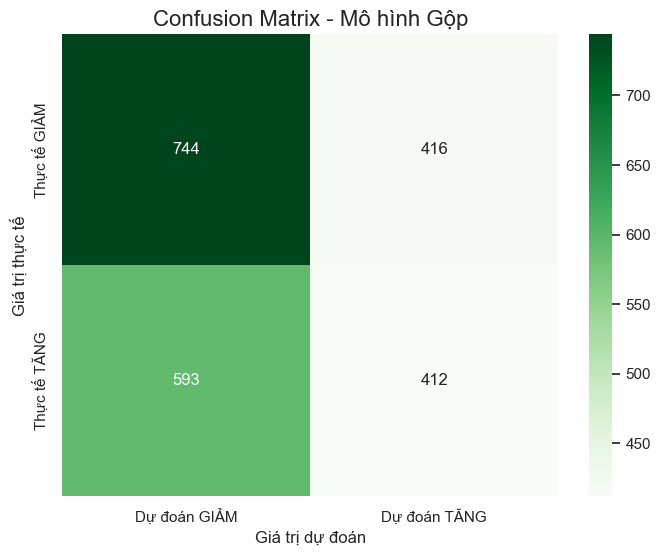

Đã lưu Confusion Matrix tại 'pooled_confusion_matrix.png'


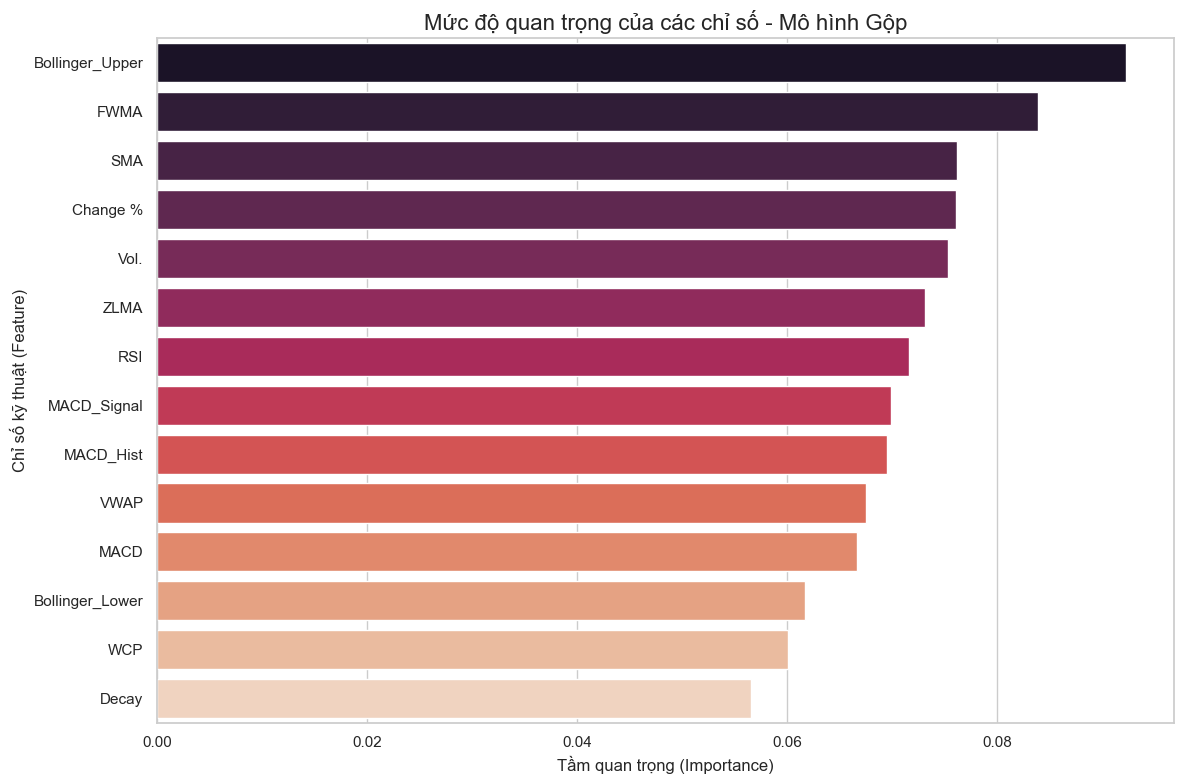

Đã lưu Feature Importance tại 'pooled_feature_importance.png'

--- Đang gom file vào thư mục 'XG BOOST _ huanluyen5ma _ 1' ---

 TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'XG BOOST _ huanluyen5ma _ 1'


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import warnings
import os
import shutil

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

try:
    # 1. ĐỌC DỮ LIỆU 
    df = pd.read_csv('stock_data_with_indicators.csv') 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])

    # 2. CHUẨN BỊ DỮ LIỆU CHO MACHINE LEARNING
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    
    # Loại bỏ NaN
    df_ml = df.dropna()

    features = ['Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay','SMA',
    'Bollinger_Upper', 'Bollinger_Lower','RSI', 'MACD', 'MACD_Signal', 'MACD_Hist']

    # Dùng cách chia theo thời gian
    print("--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---")
    train_data = df_ml[df_ml['Date'] < '2024-01-01']
    test_data = df_ml[df_ml['Date'] >= '2024-01-01']
    
    if train_data.empty or test_data.empty:
        print("Lỗi: Dữ liệu huấn luyện hoặc kiểm thử bị rỗng. Hãy kiểm tra lại mốc ngày '2024-01-01'.")
    else:
        X_train = train_data[features]
        y_train = train_data['Target']
        
        X_test = test_data[features]
        y_test = test_data['Target']

        print(f"Mẫu huấn luyện: {len(X_train)} (trước 2024-01-01)")
        print(f"Mẫu kiểm thử: {len(X_test)} (từ 2024-01-01 trở đi)")

        # 3. HUẤN LUYỆN MÔ HÌNH XGBOOST
        # TÍNH TOÁN scale_pos_weight TỪ DỮ LIỆU HUẤN LUYỆN
        count_neg = (y_train == 0).sum()
        count_pos = (y_train == 1).sum()
        
        if count_pos > 0:
            scale_pos_weight = count_neg / count_pos
            print(f"\nTính toán scale_pos_weight:")
            print(f"  Số mẫu GIẢM (0) trong tập Train: {count_neg}")
            print(f"  Số mẫu TĂNG (1) trong tập Train: {count_pos}")
            print(f"  => scale_pos_weight = {count_neg} / {count_pos} = {scale_pos_weight:.4f}")
        else:
            scale_pos_weight = 1
            print("Cảnh báo: Không tìm thấy mẫu TĂNG (1) trong tập huấn luyện.")

        print("\n--- Bắt đầu huấn luyện mô hình XGBoost (với scale_pos_weight) ---")
        
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            scale_pos_weight=scale_pos_weight 
        )
        
        model.fit(X_train, y_train)
        print("--- Mô hình XGBoost (ĐÃ CÂN BẰNG) đã huấn luyện thành công! ---")

        # 4. ĐÁNH GIÁ MÔ HÌNH
        y_pred = model.predict(X_test)
        
        print("\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH XGBOOST ---")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy của XGBoost: {accuracy:.4f}")
        
        # Tạo báo cáo dạng text (string)
        report_text = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=4)
        
        print("\nBáo cáo Phân loại chi tiết:")
        print(report_text) # In ra màn hình

        # Đặt tên file
        report_filename = 'pooled_model_report.txt'
        with open(report_filename, "w", encoding="utf-8") as f:
            f.write(f"--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH GỘP (POOLED MODEL) ---\n")
            f.write(f"Accuracy của XGBoost: {accuracy:.4f}\n\n")
            f.write("Báo cáo Phân loại chi tiết:\n")
            f.write(report_text)
        print(f"\nĐã lưu Báo cáo Phân loại tại '{report_filename}'")
        
        # 5. TRỰC QUAN HÓA KẾT QUẢ
        print("\n--- Đang tạo các biểu đồ đánh giá ---")
        
        cm_filename = 'pooled_confusion_matrix.png'
        fi_filename = 'pooled_feature_importance.png'
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                    xticklabels=['Dự đoán GIẢM', 'Dự đoán TĂNG'],
                    yticklabels=['Thực tế GIẢM', 'Thực tế TĂNG'])
        plt.title('Confusion Matrix - Mô hình Gộp', fontsize=16)
        plt.ylabel('Giá trị thực tế', fontsize=12)
        plt.xlabel('Giá trị dự đoán', fontsize=12)
        plt.savefig(cm_filename)

        plt.show() 
        plt.close()
        # ------------------------------------
        print(f"Đã lưu Confusion Matrix tại '{cm_filename}'")
        
        # Feature Importance
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')
        plt.title('Mức độ quan trọng của các chỉ số - Mô hình Gộp', fontsize=16)
        plt.xlabel('Tầm quan trọng (Importance)', fontsize=12)
        plt.ylabel('Chỉ số kỹ thuật (Feature)', fontsize=12)
        plt.tight_layout()
        plt.savefig(fi_filename)
        plt.show() 
        plt.close()
  
        print(f"Đã lưu Feature Importance tại '{fi_filename}'")

        # Lưu folder
        output_folder = "XG BOOST _ huanluyen5ma _ 1" 
        os.makedirs(output_folder, exist_ok=True) 

        # Cập nhật danh sách file
        file_patterns = [
            report_filename, 
            cm_filename,
            fi_filename
        ]

        print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
        for fname in file_patterns:
            if os.path.exists(fname): # Kiểm tra file tồn tại
                try:
                    shutil.move(fname, os.path.join(output_folder, fname))
                except Exception as e:
                    print(f"Lỗi khi di chuyển {fname}: {e}")

        print(f"\n TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện XGBoost chưa được cài đặt.")
    print("Vui lòng chạy lệnh: pip install xgboost")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

# Phân lớp _ XG Boost - Huấn luyện cả 5 mã _ với tinh chỉnh tham số cho 28 features + scale_pos_weight và thêm các tham số chống overfitting (reg_alpha, reg_lambda) vào param_dist_xgb.

--- Đang thêm Đặc trưng Tương tác ---

--- Đang thêm các Đặc trưng Trễ ---
Đã tạo: ZLMA_lag_1
Đã tạo: ZLMA_lag_2
Đã tạo: RSI_lag_1
Đã tạo: RSI_lag_2
Đã tạo: MACD_Hist_lag_1
Đã tạo: MACD_Hist_lag_2
Đã tạo: Change %_lag_1
Đã tạo: Change %_lag_2
Đã tạo: Vol._lag_1
Đã tạo: Price_vs_SMA_lag_1
Đã tạo: Bollinger_Width_Normalized_lag_1

Các features sẽ được sử dụng (28): ['Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay', 'SMA', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'Price_vs_SMA', 'Price_vs_ZLMA', 'Bollinger_Width_Normalized', 'ZLMA_lag_1', 'ZLMA_lag_2', 'RSI_lag_1', 'RSI_lag_2', 'MACD_Hist_lag_1', 'MACD_Hist_lag_2', 'Change %_lag_1', 'Change %_lag_2', 'Vol._lag_1', 'Price_vs_SMA_lag_1', 'Bollinger_Width_Normalized_lag_1']

--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---
Mẫu huấn luyện: 9895
Mẫu kiểm thử: 2165

--- Bắt đầu Tinh chỉnh Tham số Kỹ Lưỡng Hơn cho XGBoost Gộp... ---
Sử dụng scale_pos_weight = 1.1207
Fitting 5 folds for eac

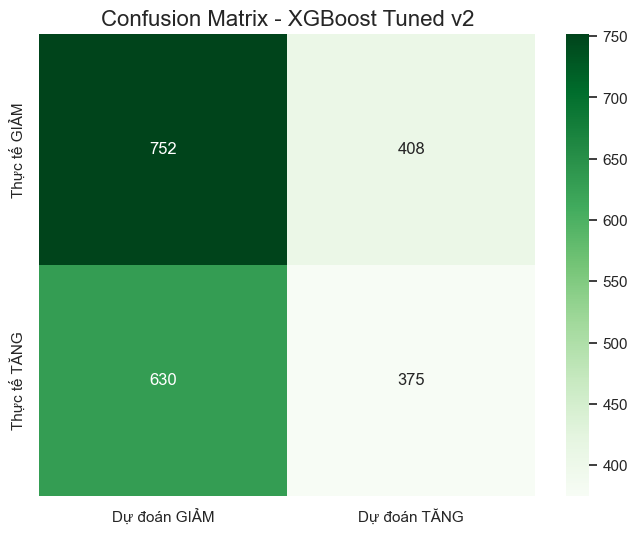

Đã lưu Confusion Matrix tại 'xgb_pooled_tuned_v2_confusion_matrix.png'


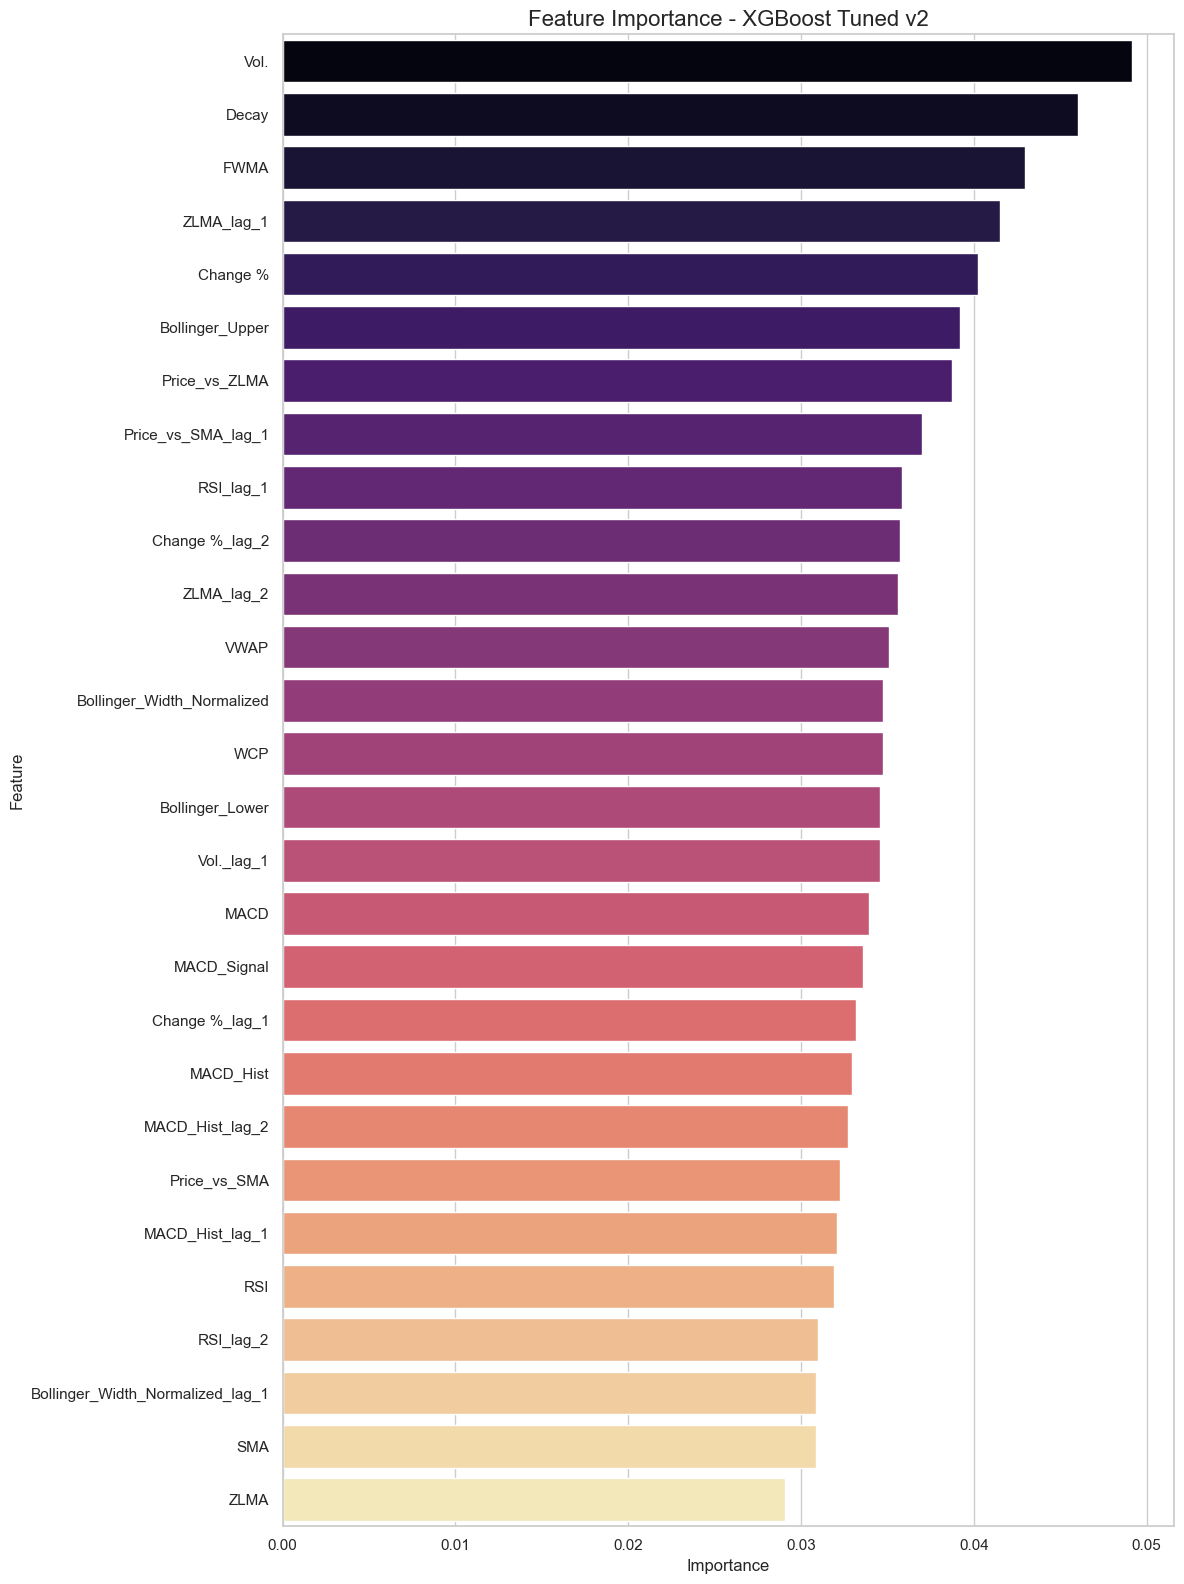

Đã lưu Feature Importance tại 'xgb_pooled_tuned_v2_feature_importance.png'

--- Đang vẽ đường cong ROC-AUC ---


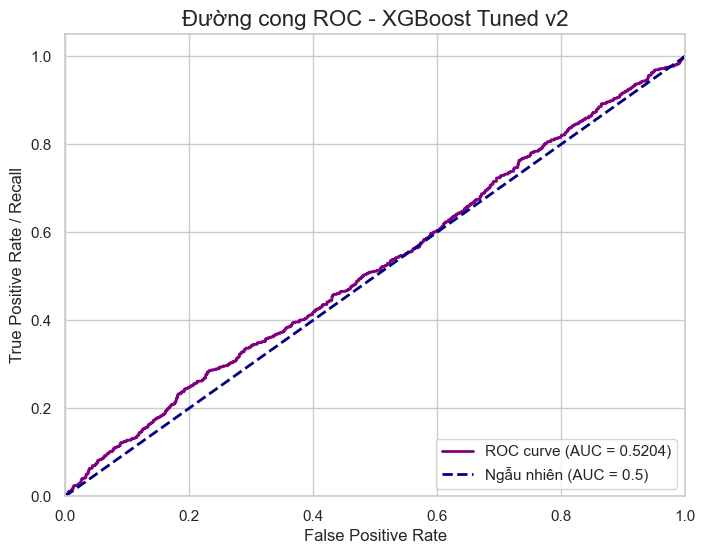

Đã lưu đường cong ROC-AUC tại 'xgb_pooled_tuned_v2_roc_curve.png' (AUC = 0.5204)

--- Đang vẽ đường cong Precision-Recall ---


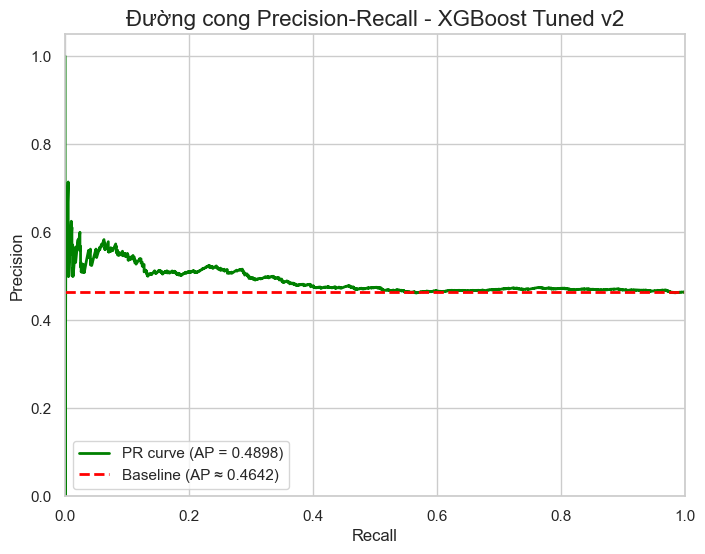

Đã lưu đường cong PR tại 'xgb_pooled_tuned_v2_pr_curve.png' (Average Precision = 0.4898)

--- Đang gom file vào thư mục 'XG BOOST _ huanluyen5ma _ 2' ---

 TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'XG BOOST _ huanluyen5ma _ 2'


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score )
import warnings
import os
import shutil
import time

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

def add_lag_and_interaction_features(df):
    """
    Hàm này thêm cả Đặc trưng Tương tác VÀ LAG.
    """
    print("--- Đang thêm Đặc trưng Tương tác ---")
    df['Price_vs_SMA'] = df['Price'] - df['SMA']
    df['Price_vs_ZLMA'] = df['Price'] - df['ZLMA']
    # Xử lý chia cho 0 tiềm ẩn
    if 'SMA' in df.columns and not df['SMA'].eq(0).all():
         df['Bollinger_Width_Normalized'] = (df['Bollinger_Upper'] - df['Bollinger_Lower']) / df['SMA']
         df['Bollinger_Width_Normalized'] = df['Bollinger_Width_Normalized'].replace([np.inf, -np.inf], np.nan)
    else:
         df['Bollinger_Width_Normalized'] = np.nan
         print("Cảnh báo: Cột 'SMA' bằng 0 hoặc không tồn tại, 'Bollinger_Width_Normalized' được gán NaN.")

    # 2. Thêm Đặc trưng Trễ 
    print("\n--- Đang thêm các Đặc trưng Trễ ---")
    features_to_lag = {
        'ZLMA': [1, 2], 'RSI': [1, 2], 'MACD_Hist': [1, 2],
        'Change %': [1, 2], 'Vol.': [1],
        'Price_vs_SMA': [1], 'Bollinger_Width_Normalized': [1]
    }
    for feature, lags in features_to_lag.items():
        if feature not in df.columns:
            print(f"Cảnh báo: Không tìm thấy cột '{feature}' để tạo lag.")
            continue
        for lag in lags:
            col_name = f"{feature}_lag_{lag}"
            df[col_name] = df.groupby('Ticker')[feature].shift(lag)
            print(f"Đã tạo: {col_name}")
    return df

try:
    # 1. ĐỌC DỮ LIỆU
    df = pd.read_csv('stock_data_with_indicators.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])

    # 2. CHUẨN BỊ DỮ LIỆU
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    df_with_features = add_lag_and_interaction_features(df)
    df_ml = df_with_features.dropna()

    # --- DANH SÁCH 28 FEATURES ---
    base_features = [
        'Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay','SMA',
        'Bollinger_Upper', 'Bollinger_Lower','RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'
    ]
    interaction_features = ['Price_vs_SMA', 'Price_vs_ZLMA', 'Bollinger_Width_Normalized']
    lag_features = [
        'ZLMA_lag_1', 'ZLMA_lag_2', 'RSI_lag_1', 'RSI_lag_2',
        'MACD_Hist_lag_1', 'MACD_Hist_lag_2', 'Change %_lag_1', 'Change %_lag_2',
        'Vol._lag_1', 'Price_vs_SMA_lag_1', 'Bollinger_Width_Normalized_lag_1'
    ]
    all_features = [f for f in base_features + interaction_features + lag_features if f in df_ml.columns]
    print(f"\nCác features sẽ được sử dụng ({len(all_features)}): {all_features}")

    # 3. CHIA DỮ LIỆU (Dùng cách chia theo thời gian)
    print("\n--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---")
    train_data = df_ml[df_ml['Date'] < '2024-01-01']
    test_data = df_ml[df_ml['Date'] >= '2024-01-01']

    if train_data.empty or test_data.empty:
        print("Lỗi: Dữ liệu huấn luyện hoặc kiểm thử bị rỗng.")
    else:
        X_train = train_data[all_features]
        y_train = train_data['Target']
        X_test = test_data[all_features]
        y_test = test_data['Target']

        print(f"Mẫu huấn luyện: {len(X_train)}")
        print(f"Mẫu kiểm thử: {len(X_test)}")

        # 4. TINH CHỈNH THAM SỐ KỸ LƯỠNG HƠN
        print("\n--- Bắt đầu Tinh chỉnh Tham số Kỹ Lưỡng Hơn cho XGBoost Gộp... ---")
        start_tune_time = time.time()

        # 4.1 Tính scale_pos_weight
        count_neg = (y_train == 0).sum()
        count_pos = (y_train == 1).sum()
        scale_pos_weight = 1 if count_pos == 0 else (count_neg / count_pos)
        print(f"Sử dụng scale_pos_weight = {scale_pos_weight:.4f}")

        # 4.2 Định nghĩa "Menu" tham số (Mở rộng + Thêm Regularization)
        param_dist_xgb = {
            'n_estimators': [100, 200, 300, 400, 500, 700], 
            'max_depth': [3, 4, 5, 6, 7], 
            'learning_rate': [0.01, 0.02, 0.05, 0.1],
            'subsample': [0.7, 0.8, 0.9], 
            'colsample_bytree': [0.7, 0.8, 0.9], 
            'gamma': [0, 0.1, 0.2, 0.3], 
            'reg_alpha': [0, 0.001, 0.01, 0.1, 1.0], # L1 regularization
            'reg_lambda': [0.1, 1.0, 2.0, 5.0]     # L2 regularization
        }

        # 4.3 Tạo mô hình XGBoost cơ sở
        model_base_xgb = xgb.XGBClassifier(
            objective='binary:logistic', use_label_encoder=False,
            eval_metric='logloss', # Giữ logloss làm metric đánh giá nội bộ
            random_state=42,
            scale_pos_weight=scale_pos_weight
        )

        # 4.4 Cài đặt TimeSeriesSplit
        tscv_xgb = TimeSeriesSplit(n_splits=5)

        # 4.5 Cài đặt RandomizedSearchCV (Thay đổi n_iter và scoring)
        random_search_xgb = RandomizedSearchCV(
            estimator=model_base_xgb, param_distributions=param_dist_xgb,
            n_iter=50, 
            scoring='average_precision', 
            cv=tscv_xgb,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )

        # 4.6 Chạy quá trình "dò"
        random_search_xgb.fit(X_train, y_train)

        end_tune_time = time.time()
        print(f"--- Tinh chỉnh XGBoost Gộp (Kỹ hơn) hoàn tất! (Thời gian: {((end_tune_time - start_tune_time) / 60):.2f} phút) ---")
        print(f"Bộ tham số tốt nhất (tối ưu theo Average Precision): {random_search_xgb.best_params_}")
        print(f"Điểm Average Precision tốt nhất trên tập huấn luyện (cross-val): {random_search_xgb.best_score_:.4f}")

        # 5. ĐÁNH GIÁ MÔ HÌNH XGBOOST TỐT NHẤT
        best_xgb_model = random_search_xgb.best_estimator_

        # Lấy xác suất và dự đoán lớp (ngưỡng 0.5)
        y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba_xgb > 0.5).astype(int)

        print("\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH XGBOOST GỘP - TINH CHỈNH KỸ HƠN ---")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy của XGBoost Gộp - TINH CHỈNH KỸ HƠN: {accuracy:.4f}")
        report_text = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=4)
        print("\nBáo cáo Phân loại chi tiết:")
        print(report_text)

        # 6. LƯU KẾT QUẢ VÀ VẼ BIỂU ĐỒ
        output_folder = "XG BOOST _ huanluyen5ma _ 2" 
        os.makedirs(output_folder, exist_ok=True)

        report_filename = 'xgb_pooled_tuned_v2_report.txt'
        cm_filename = 'xgb_pooled_tuned_v2_confusion_matrix.png'
        fi_filename = 'xgb_pooled_tuned_v2_feature_importance.png'
        roc_filename = 'xgb_pooled_tuned_v2_roc_curve.png'
        pr_filename = 'xgb_pooled_tuned_v2_pr_curve.png'

        # Lưu Báo cáo .txt
        with open(report_filename, "w", encoding="utf-8") as f:
            f.write(f"--- KẾT QUẢ XGBOOST GỘP - TINH CHỈNH KỸ HƠN ({len(all_features)} Features) ---\n")
            f.write(f"Scoring: average_precision, n_iter: 50\n")
            f.write(f"Tham số tốt nhất: {random_search_xgb.best_params_}\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write(report_text)
        print(f"\nĐã lưu Báo cáo Phân loại tại '{report_filename}'")

        # Vẽ và lưu Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Dự đoán GIẢM', 'Dự đoán TĂNG'], yticklabels=['Thực tế GIẢM', 'Thực tế TĂNG'])
        plt.title('Confusion Matrix - XGBoost Tuned v2', fontsize=16); plt.savefig(cm_filename); plt.show(); plt.close()
        print(f"Đã lưu Confusion Matrix tại '{cm_filename}'")

        # Vẽ và lưu Feature Importance
        if hasattr(best_xgb_model, 'feature_importances_'):
             importances = best_xgb_model.feature_importances_
             if len(importances) == len(all_features):
                  feature_importance_df = pd.DataFrame({'Feature': all_features,'Importance': importances}).sort_values(by='Importance', ascending=False)
                  plt.figure(figsize=(12, 16)); sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
                  plt.title('Feature Importance - XGBoost Tuned v2', fontsize=16); plt.tight_layout(); plt.savefig(fi_filename); plt.show(); plt.close()
                  print(f"Đã lưu Feature Importance tại '{fi_filename}'")
             else: fi_filename = None
        else: fi_filename = None

        # VẼ ĐƯỜNG CONG ROC-AUC 
        print("\n--- Đang vẽ đường cong ROC-AUC ---")
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb); roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6)); plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ngẫu nhiên (AUC = 0.5)')
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate / Recall')
        plt.title('Đường cong ROC - XGBoost Tuned v2', fontsize=16); plt.legend(loc="lower right"); plt.grid(True)
        plt.savefig(roc_filename); plt.show(); plt.close()
        print(f"Đã lưu đường cong ROC-AUC tại '{roc_filename}' (AUC = {roc_auc:.4f})")

        # VẼ ĐƯỜNG CONG PRECISION-RECALL
        print("\n--- Đang vẽ đường cong Precision-Recall ---")
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb); average_precision = average_precision_score(y_test, y_pred_proba_xgb)
        baseline = (y_test == 1).sum() / len(y_test)
        plt.figure(figsize=(8, 6)); plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {average_precision:.4f})')
        plt.axhline(baseline, color='red', lw=2, linestyle='--', label=f'Baseline (AP ≈ {baseline:.4f})')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0])
        plt.title('Đường cong Precision-Recall - XGBoost Tuned v2', fontsize=16); plt.legend(loc="lower left"); plt.grid(True)
        plt.savefig(pr_filename); plt.show(); plt.close()
        print(f"Đã lưu đường cong PR tại '{pr_filename}' (Average Precision = {average_precision:.4f})")

        # Gom file
        print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
        files_to_move = [report_filename, cm_filename, roc_filename, pr_filename]
        if fi_filename: files_to_move.append(fi_filename)
        for fname in files_to_move:
            if os.path.exists(fname):
                try: shutil.move(fname, os.path.join(output_folder, fname))
                except Exception as e: print(f"Lỗi khi di chuyển {fname}: {e}")
        print(f"\n TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện XGBoost hoặc các thư viện khác chưa được cài đặt.")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

# Phân lớp _ Random Forest 
Có tinh chỉnh tham số cho mô hình Random Forest bằng RandomizedSearchCV và TimeSeriesSplit để tìm ra bộ cài đặt (n_estimators, max_depth, min_samples_split...) tốt nhất cho mô hình.

--- Đang thêm Đặc trưng Tương tác ---

--- Đang thêm các Đặc trưng Trễ ---
Đã tạo: ZLMA_lag_1
Đã tạo: ZLMA_lag_2
Đã tạo: RSI_lag_1
Đã tạo: RSI_lag_2
Đã tạo: MACD_Hist_lag_1
Đã tạo: MACD_Hist_lag_2
Đã tạo: Change %_lag_1
Đã tạo: Change %_lag_2
Đã tạo: Vol._lag_1
Đã tạo: Price_vs_SMA_lag_1
Đã tạo: Bollinger_Width_Normalized_lag_1

Các features sẽ được sử dụng (28): ['Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay', 'SMA', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'Price_vs_SMA', 'Price_vs_ZLMA', 'Bollinger_Width_Normalized', 'ZLMA_lag_1', 'ZLMA_lag_2', 'RSI_lag_1', 'RSI_lag_2', 'MACD_Hist_lag_1', 'MACD_Hist_lag_2', 'Change %_lag_1', 'Change %_lag_2', 'Vol._lag_1', 'Price_vs_SMA_lag_1', 'Bollinger_Width_Normalized_lag_1']

--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---
Mẫu huấn luyện: 9895
Mẫu kiểm thử: 2165

--- Bắt đầu Tinh chỉnh Tham số cho Random Forest... ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- Ti

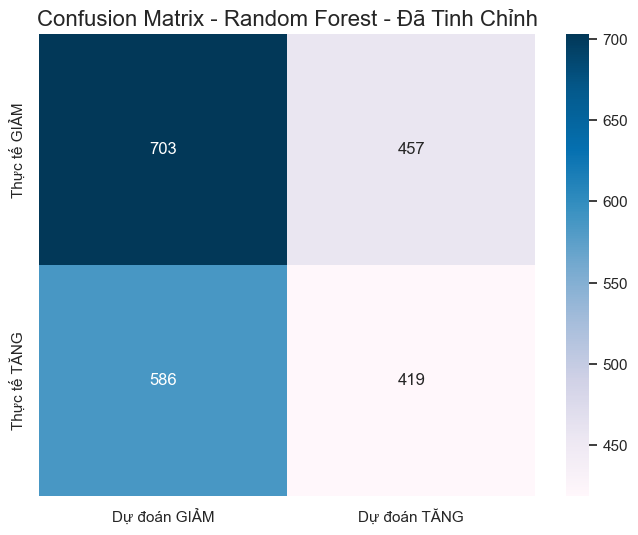

Đã lưu Confusion Matrix tại 'rf_tuned_confusion_matrix.png'


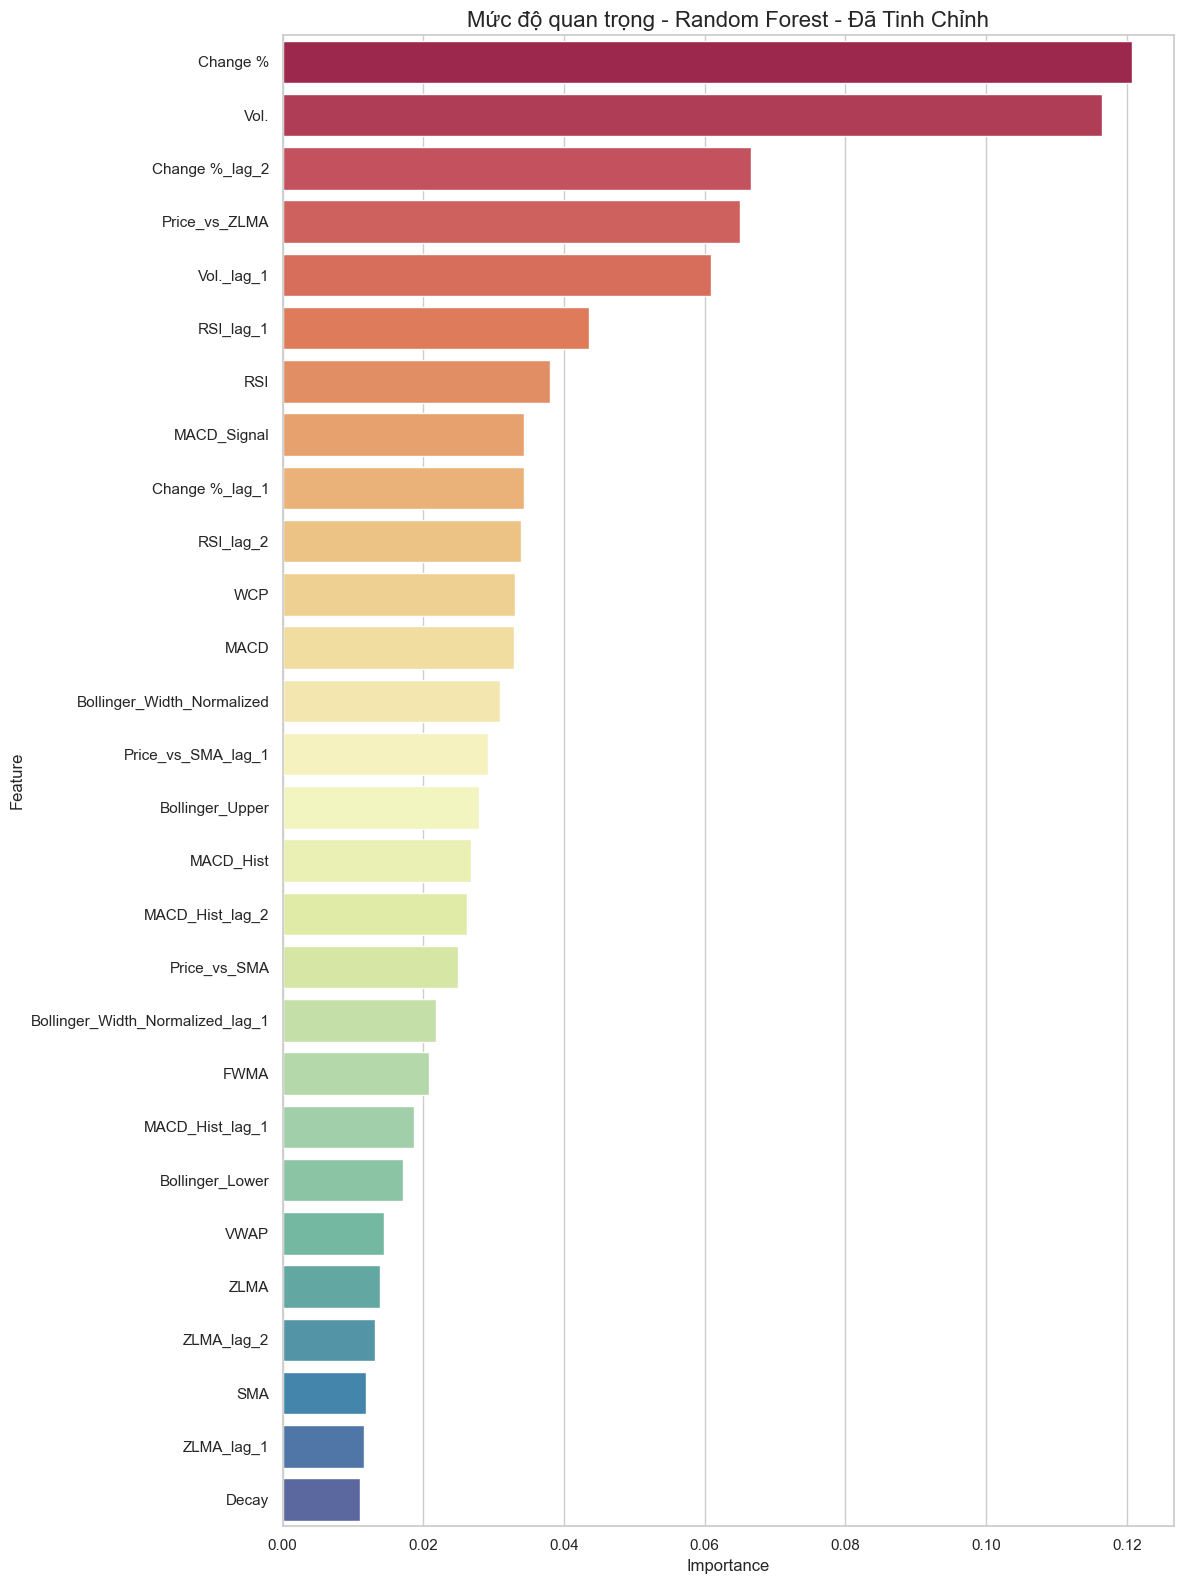

Đã lưu Feature Importance tại 'rf_tuned_feature_importance.png'

--- Đang vẽ đường cong ROC-AUC cho Random Forest Tuned ---


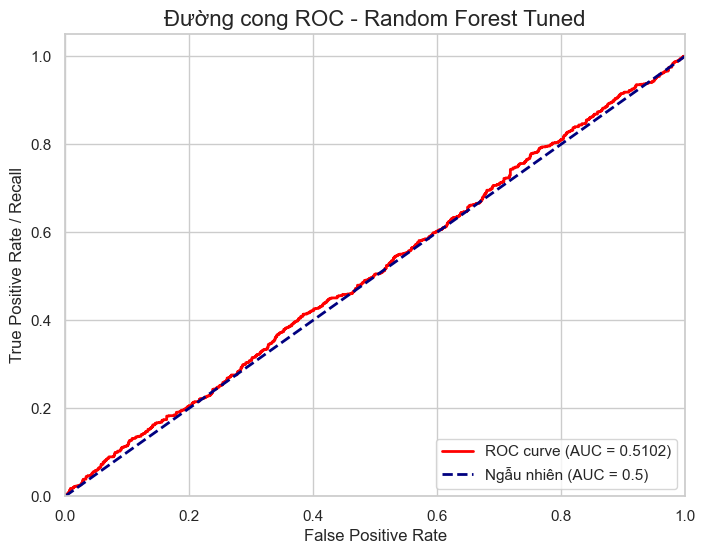

Đã lưu đường cong ROC-AUC tại 'rf_tuned_roc_curve.png' (AUC = 0.5102)

--- Đang vẽ đường cong Precision-Recall cho Random Forest Tuned ---


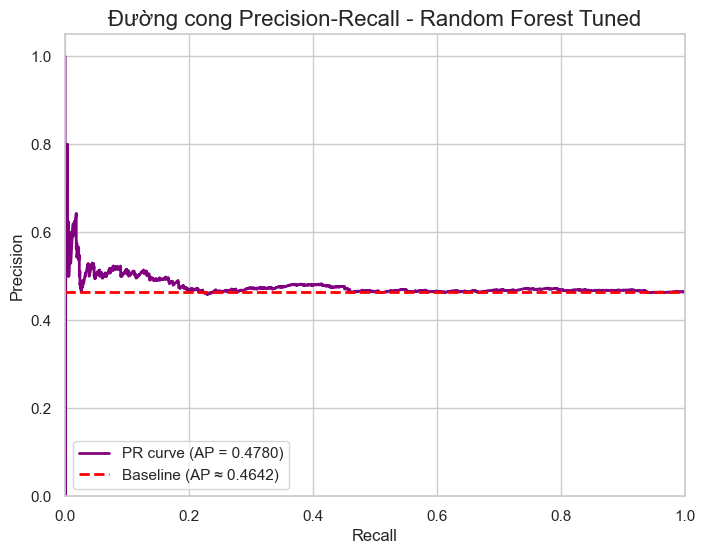

Đã lưu đường cong PR tại 'rf_tuned_pr_curve.png' (Average Precision = 0.4780)

--- Đang gom file vào thư mục 'random_forest_model' ---

 TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'random_forest_model'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit # Thêm Tuning
from sklearn.metrics import ( accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score )
import warnings
import os
import shutil
import time

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

def add_lag_and_interaction_features(df):
    """
   Đặc trưng Tương tác và LAG
    """
    # 1. Thêm Đặc trưng Tương tác 
    print("--- Đang thêm Đặc trưng Tương tác ---")
    df['Price_vs_SMA'] = df['Price'] - df['SMA']
    df['Price_vs_ZLMA'] = df['Price'] - df['ZLMA']
    # Xử lý chia cho 0 tiềm ẩn
    if 'SMA' in df.columns and not df['SMA'].eq(0).all():
         df['Bollinger_Width_Normalized'] = (df['Bollinger_Upper'] - df['Bollinger_Lower']) / df['SMA']
         df['Bollinger_Width_Normalized'] = df['Bollinger_Width_Normalized'].replace([np.inf, -np.inf], np.nan)
    else:
         df['Bollinger_Width_Normalized'] = np.nan
         print("Cảnh báo: Cột 'SMA' bằng 0 hoặc không tồn tại, 'Bollinger_Width_Normalized' được gán NaN.")

    # 2. Thêm LAG
    print("\n--- Đang thêm các Đặc trưng Trễ ---")
    features_to_lag = {
        'ZLMA': [1, 2], 'RSI': [1, 2], 'MACD_Hist': [1, 2],
        'Change %': [1, 2], 'Vol.': [1],
        'Price_vs_SMA': [1], 'Bollinger_Width_Normalized': [1]
    }
    for feature, lags in features_to_lag.items():
        if feature not in df.columns:
             print(f"Cảnh báo: Không tìm thấy cột '{feature}' để tạo lag.")
             continue
        for lag in lags:
            col_name = f"{feature}_lag_{lag}"
            df[col_name] = df.groupby('Ticker')[feature].shift(lag)
            print(f"Đã tạo: {col_name}")
    return df

try:
    # 1. ĐỌC DỮ LIỆU
    df = pd.read_csv('stock_data_with_indicators.csv') 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])

    # 2. CHUẨN BỊ DỮ LIỆU
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    df_with_features = add_lag_and_interaction_features(df)
    df_ml = df_with_features.dropna()

    # --- DANH SÁCH 28 FEATURES ---
    base_features = [
        'Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay','SMA',
        'Bollinger_Upper', 'Bollinger_Lower','RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'
    ]
    interaction_features = ['Price_vs_SMA', 'Price_vs_ZLMA', 'Bollinger_Width_Normalized']
    lag_features = [
        'ZLMA_lag_1', 'ZLMA_lag_2', 'RSI_lag_1', 'RSI_lag_2',
        'MACD_Hist_lag_1', 'MACD_Hist_lag_2', 'Change %_lag_1', 'Change %_lag_2',
        'Vol._lag_1', 'Price_vs_SMA_lag_1', 'Bollinger_Width_Normalized_lag_1'
    ]
    all_features = [f for f in base_features + interaction_features + lag_features if f in df_ml.columns]
    print(f"\nCác features sẽ được sử dụng ({len(all_features)}): {all_features}")

    # 3. CHIA DỮ LIỆU (Dùng cách chia theo thời gian)
    print("\n--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---")
    train_data = df_ml[df_ml['Date'] < '2024-01-01']
    test_data = df_ml[df_ml['Date'] >= '2024-01-01']

    if train_data.empty or test_data.empty:
        print("Lỗi: Dữ liệu huấn luyện hoặc kiểm thử bị rỗng.")
    else:
        X_train = train_data[all_features]
        y_train = train_data['Target']
        X_test = test_data[all_features]
        y_test = test_data['Target']

        print(f"Mẫu huấn luyện: {len(X_train)}")
        print(f"Mẫu kiểm thử: {len(X_test)}")

        # 4. TINH CHỈNH THAM SỐ CHO RANDOM FOREST
        print("\n--- Bắt đầu Tinh chỉnh Tham số cho Random Forest... ---")
        start_tune_time = time.time()

        # 4.1 Định nghĩa "Menu" tham số 
        param_dist_rf = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [5, 10, 15, None], # None = không giới hạn
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 3, 5],
            'max_features': ['sqrt', 'log2', 0.7] # Thêm 70% features
        }

        # 4.2 Tạo mô hình Random Forest cơ sở
        # class_weight='balanced' sẽ xử lý mất cân bằng
        model_base_rf = RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )

        # 4.3 Cài đặt TimeSeriesSplit
        tscv_rf = TimeSeriesSplit(n_splits=5)

        # 4.4 Cài đặt RandomizedSearchCV
        random_search_rf = RandomizedSearchCV(
            estimator=model_base_rf,
            param_distributions=param_dist_rf,
            n_iter=50,
            scoring='accuracy', 
            cv=tscv_rf,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )

        # 4.5 Chạy quá trình "dò"
        random_search_rf.fit(X_train, y_train) # Dùng X_train gốc (không scale)

        end_tune_time = time.time()
        print(f"--- Tinh chỉnh Random Forest hoàn tất! (Thời gian: {((end_tune_time - start_tune_time) / 60):.2f} phút) ---")
        print(f"Bộ tham số tốt nhất: {random_search_rf.best_params_}")
        print(f"Độ chính xác tốt nhất trên tập huấn luyện (cross-val): {random_search_rf.best_score_:.4f}")

        # 5. ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST 
        best_rf_model = random_search_rf.best_estimator_

        # Lấy xác suất và dự đoán lớp
        y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1] # Dùng X_test gốc
        y_pred = (y_pred_proba_rf > 0.5).astype(int)

        print("\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST - ĐÃ TINH CHỈNH ---")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy của Random Forest - ĐÃ TINH CHỈNH: {accuracy:.4f}")
        report_text = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=4)
        print("\nBáo cáo Phân loại chi tiết:")
        print(report_text)

        # 6. LƯU KẾT QUẢ VÀ VẼ BIỂU ĐỒ
        output_folder = "random_forest_model" 
        os.makedirs(output_folder, exist_ok=True)

        report_filename = 'rf_tuned_report.txt' 
        cm_filename = 'rf_tuned_confusion_matrix.png' 
        fi_filename = 'rf_tuned_feature_importance.png' 
        roc_filename = 'rf_tuned_roc_curve.png' 
        pr_filename = 'rf_tuned_pr_curve.png' 

        # Lưu Báo cáo .txt
        with open(report_filename, "w", encoding="utf-8") as f:
            f.write(f"--- KẾT QUẢ RANDOM FOREST - ĐÃ TINH CHỈNH ({len(all_features)} Features) ---\n")
            f.write(f"Tham số tốt nhất: {random_search_rf.best_params_}\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write(report_text)
        print(f"\nĐã lưu Báo cáo Phân loại tại '{report_filename}'")

        # Vẽ và lưu Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', 
                    xticklabels=['Dự đoán GIẢM', 'Dự đoán TĂNG'],
                    yticklabels=['Thực tế GIẢM', 'Thực tế TĂNG'])
        plt.title('Confusion Matrix - Random Forest - Đã Tinh Chỉnh', fontsize=16)
        plt.savefig(cm_filename)
        plt.show()
        plt.close()
        print(f"Đã lưu Confusion Matrix tại '{cm_filename}'")

        # Vẽ và lưu Feature Importance
        # Kiểm tra xem best_rf_model có feature_importances_ không
        if hasattr(best_rf_model, 'feature_importances_'):
             importances = best_rf_model.feature_importances_
             if len(importances) == len(all_features):
                  feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
                  plt.figure(figsize=(12, 16))
                  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Spectral') # Đổi màu
                  plt.title('Mức độ quan trọng - Random Forest - Đã Tinh Chỉnh', fontsize=16)
                  plt.tight_layout()
                  plt.savefig(fi_filename)
                  plt.show()
                  plt.close()
                  print(f"Đã lưu Feature Importance tại '{fi_filename}'")
             else:
                  print("Cảnh báo: Số lượng feature importances không khớp.")
                  fi_filename = None
        else:
             print("Cảnh báo: Mô hình RF không có feature_importances_.")
             fi_filename = None

        # VẼ ĐƯỜNG CONG ROC-AUC 
        print("\n--- Đang vẽ đường cong ROC-AUC cho Random Forest Tuned ---")
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_rf)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})') # Đổi màu
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ngẫu nhiên (AUC = 0.5)')
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate / Recall')
        plt.title('Đường cong ROC - Random Forest Tuned', fontsize=16)
        plt.legend(loc="lower right"); plt.grid(True)
        plt.savefig(roc_filename)
        plt.show()
        plt.close()
        print(f"Đã lưu đường cong ROC-AUC tại '{roc_filename}' (AUC = {roc_auc:.4f})")

        # VẼ ĐƯỜNG CONG PRECISION-RECALL 
        print("\n--- Đang vẽ đường cong Precision-Recall cho Random Forest Tuned ---")
        precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_rf)
        average_precision = average_precision_score(y_test, y_pred_proba_rf)
        baseline = (y_test == 1).sum() / len(y_test)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {average_precision:.4f})') # Đổi màu
        plt.axhline(baseline, color='red', lw=2, linestyle='--', label=f'Baseline (AP ≈ {baseline:.4f})')
        plt.xlabel('Recall'); plt.ylabel('Precision')
        plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0])
        plt.title('Đường cong Precision-Recall - Random Forest Tuned', fontsize=16)
        plt.legend(loc="lower left"); plt.grid(True)
        plt.savefig(pr_filename)
        plt.show()
        plt.close()
        print(f"Đã lưu đường cong PR tại '{pr_filename}' (Average Precision = {average_precision:.4f})")

        # Gom file
        print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
        files_to_move = [report_filename, cm_filename, roc_filename, pr_filename]
        if fi_filename: files_to_move.append(fi_filename)
        for fname in files_to_move:
            if os.path.exists(fname):
                try:
                    shutil.move(fname, os.path.join(output_folder, fname))
                except Exception as e:
                    print(f"Lỗi khi di chuyển {fname}: {e}")

        print(f"\n TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện (ví dụ: sklearn) chưa được cài đặt.")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

--- Đang thêm Đặc trưng Tương tác ---
Đã tạo: Price_vs_SMA, Price_vs_ZLMA, Bollinger_Width_Normalized

--- Đang thêm các Đặc trưng Trễ ---
Đã tạo cột: ZLMA_lag_1
Đã tạo cột: ZLMA_lag_2
Đã tạo cột: RSI_lag_1
Đã tạo cột: RSI_lag_2
Đã tạo cột: MACD_Hist_lag_1
Đã tạo cột: MACD_Hist_lag_2
Đã tạo cột: Change %_lag_1
Đã tạo cột: Change %_lag_2
Đã tạo cột: Vol._lag_1
Đã tạo cột: Price_vs_SMA_lag_1
Đã tạo cột: Bollinger_Width_Normalized_lag_1

--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---
Tổng số features: 28
Mẫu huấn luyện: 9895
Mẫu kiểm thử: 2165

--- Bắt đầu huấn luyện mô hình Random Forest ---
--- Mô hình Random Forest đã huấn luyện thành công! ---

--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST ---
Accuracy của Random Forest: 0.5229

Báo cáo Phân loại chi tiết:
              precision    recall  f1-score   support

    GIẢM (0)     0.5392    0.7534    0.6286      1160
    TĂNG (1)     0.4743    0.2567    0.3331      1005

    accuracy                         0.5229      2165
   macro

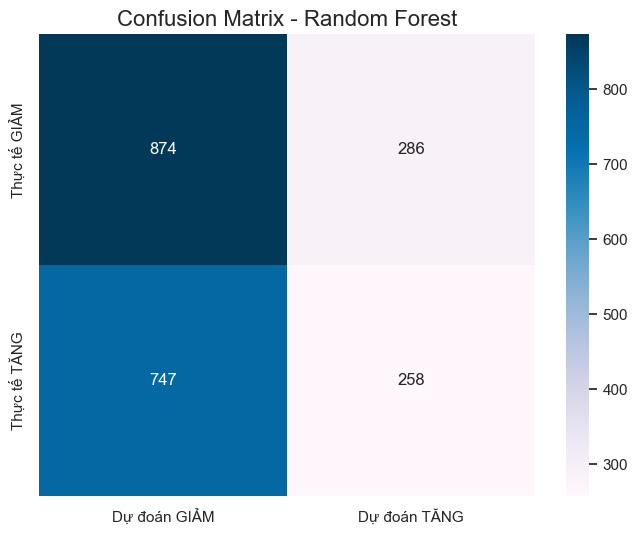

Đã lưu Confusion Matrix tại 'rf_confusion_matrix.png'


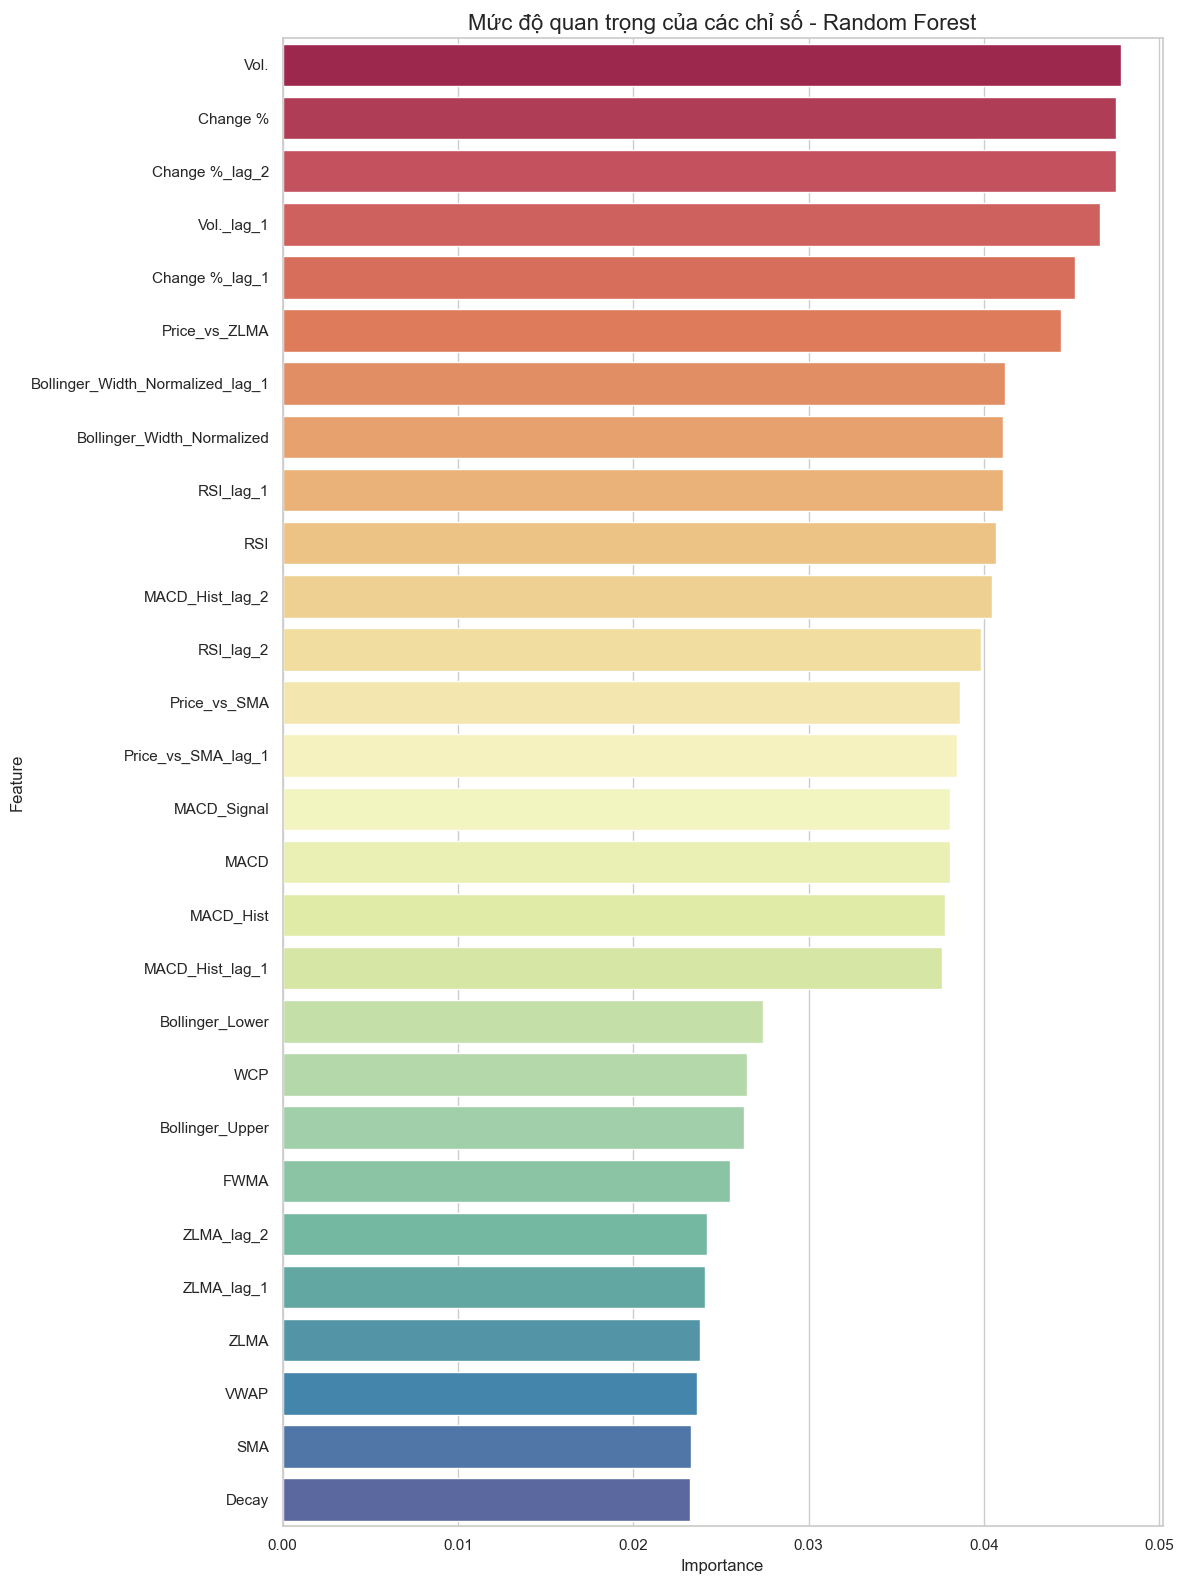

Đã lưu Feature Importance tại 'rf_feature_importance.png'

--- Đang gom file vào thư mục 'random_forest_model' ---

 TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'random_forest_model'


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import os
import shutil

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

def add_lag_and_interaction_features(df):
    """
    Hàm này thêm cả Đặc trưng Tương tác VÀ Đặc trưng Trễ.
    """
    # --- 1. Thêm Đặc trưng Tương tác (Interaction Features) ---
    print("--- Đang thêm Đặc trưng Tương tác ---")
    df['Price_vs_SMA'] = df['Price'] - df['SMA']
    df['Price_vs_ZLMA'] = df['Price'] - df['ZLMA']
    df['Bollinger_Width_Normalized'] = (df['Bollinger_Upper'] - df['Bollinger_Lower']) / df['SMA']
    print("Đã tạo: Price_vs_SMA, Price_vs_ZLMA, Bollinger_Width_Normalized")

    # --- 2. Thêm Đặc trưng Trễ (Lag Features) ---
    print("\n--- Đang thêm các Đặc trưng Trễ ---")
    
    features_to_lag = {
        'ZLMA': [1, 2], 'RSI': [1, 2], 'MACD_Hist': [1, 2],
        'Change %': [1, 2], 'Vol.': [1],
        'Price_vs_SMA': [1], 'Bollinger_Width_Normalized': [1]
    }
    
    for feature, lags in features_to_lag.items():
        if feature not in df.columns:
            print(f"Cảnh báo: Không tìm thấy cột '{feature}' để tạo lag.")
            continue
            
        for lag in lags:
            col_name = f"{feature}_lag_{lag}"
            df[col_name] = df.groupby('Ticker')[feature].shift(lag)
            print(f"Đã tạo cột: {col_name}")
            
    return df

try:
    # 1. ĐỌC DỮ LIỆU 
    df = pd.read_csv('stock_data_with_indicators.csv') 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])

    # 2. CHUẨN BỊ DỮ LIỆU
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    
    df_with_features = add_lag_and_interaction_features(df)
    
    df_ml = df_with_features.dropna()

    # --- DANH SÁCH 28 FEATURES ---
    base_features = [
        'Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay','SMA',
        'Bollinger_Upper', 'Bollinger_Lower','RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'
    ]
    interaction_features = [
        'Price_vs_SMA', 'Price_vs_ZLMA', 'Bollinger_Width_Normalized'
    ]
    lag_features = [
        'ZLMA_lag_1', 'ZLMA_lag_2', 'RSI_lag_1', 'RSI_lag_2',
        'MACD_Hist_lag_1', 'MACD_Hist_lag_2', 'Change %_lag_1', 'Change %_lag_2',
        'Vol._lag_1', 'Price_vs_SMA_lag_1', 'Bollinger_Width_Normalized_lag_1'
    ]
    all_features = base_features + interaction_features + lag_features

    # 3. CHIA DỮ LIỆU (Dùng cách chia theo thời gian)
    print("\n--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---")
    train_data = df_ml[df_ml['Date'] < '2024-01-01']
    test_data = df_ml[df_ml['Date'] >= '2024-01-01']
    
    if train_data.empty or test_data.empty:
        print("Lỗi: Dữ liệu huấn luyện hoặc kiểm thử bị rỗng. Hãy kiểm tra lại mốc ngày '2024-01-01'.")
    else:
        X_train = train_data[all_features]
        y_train = train_data['Target']
        
        X_test = test_data[all_features]
        y_test = test_data['Target']

        print(f"Tổng số features: {len(all_features)}")
        print(f"Mẫu huấn luyện: {len(X_train)}")
        print(f"Mẫu kiểm thử: {len(X_test)}")

        # 4. HUẤN LUYỆN MÔ HÌNH RANDOM FOREST
        print("\n--- Bắt đầu huấn luyện mô hình Random Forest ---")
        
        model = RandomForestClassifier(
            n_estimators=100,       # 100 cây (mặc định hợp lý)
            random_state=42,
            class_weight='balanced', # Tự động xử lý mất cân bằng
            n_jobs=-1               # Dùng tất cả CPU
        )
        
        model.fit(X_train, y_train)
        print("--- Mô hình Random Forest đã huấn luyện thành công! ---")

        # 5. ĐÁNH GIÁ MÔ HÌNH
        y_pred = model.predict(X_test)
        
        print("\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST ---")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy của Random Forest: {accuracy:.4f}")
        
        report_text = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=4)
        print("\nBáo cáo Phân loại chi tiết:")
        print(report_text) 

        # 6. LƯU KẾT QUẢ
        output_folder = "random_forest_model"
        os.makedirs(output_folder, exist_ok=True) 
        
        report_filename = 'rf_report.txt'
        cm_filename = 'rf_confusion_matrix.png'
        fi_filename = 'rf_feature_importance.png'
        
        # Lưu Báo cáo .txt
        with open(report_filename, "w", encoding="utf-8") as f:
            f.write(f"--- KẾT QUẢ MÔ HÌNH RANDOM FOREST (28 Features) ---\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write(report_text)
        print(f"\nĐã lưu Báo cáo Phân loại tại '{report_filename}'")

        # Vẽ và lưu Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', 
                    xticklabels=['Dự đoán GIẢM', 'Dự đoán TĂNG'],
                    yticklabels=['Thực tế GIẢM', 'Thực tế TĂNG'])
        plt.title('Confusion Matrix - Random Forest', fontsize=16)
        plt.savefig(cm_filename)
        plt.show() # HIỆN BIỂU ĐỒ
        plt.close()
        print(f"Đã lưu Confusion Matrix tại '{cm_filename}'")
        
        # Vẽ và lưu Feature Importance
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': all_features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(12, 16)) 
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Spectral')
        plt.title('Mức độ quan trọng của các chỉ số - Random Forest', fontsize=16)
        plt.tight_layout()
        plt.savefig(fi_filename)
        plt.show() # HIỆN BIỂU ĐỒ
        plt.close()
        print(f"Đã lưu Feature Importance tại '{fi_filename}'")
        
        # Gom file
        print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
        for fname in [report_filename, cm_filename, fi_filename]:
            if os.path.exists(fname):
                try:
                    shutil.move(fname, os.path.join(output_folder, fname))
                except Exception as e:
                    print(f"Lỗi khi di chuyển {fname}: {e}")

        print(f"\n TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện (ví dụ: sklearn) chưa được cài đặt.")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

# Phân lớp - SVM _ SVC

--- Đang thêm Đặc trưng Tương tác ---

--- Đang thêm các Đặc trưng Trễ ---

--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---
Tổng số features: 28
Mẫu huấn luyện: 9895
Mẫu kiểm thử: 2165

--- Đang chuẩn hóa (Scaling) dữ liệu cho SVM ---

--- Bắt đầu Tinh chỉnh Tham số cho SVM (SVC)... ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits
--- Tinh chỉnh SVM hoàn tất! (Thời gian: 1.79 phút) ---
Bộ tham số C, gamma tốt nhất: {'gamma': np.float64(0.001), 'C': np.float64(0.21544346900318834)}
Độ chính xác tốt nhất trên tập huấn luyện (cross-val): 0.5402

--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH SVM (SVC) - ĐÃ TINH CHỈNH ---
Accuracy của SVM (SVC) - ĐÃ TINH CHỈNH: 0.5501

Báo cáo Phân loại chi tiết:
              precision    recall  f1-score   support

    GIẢM (0)     0.5618    0.7293    0.6347      1160
    TĂNG (1)     0.5235    0.3433    0.4147      1005

    accuracy                         0.5501      2165
   macro avg     0.5426    0.5363    0.5247      2165
weighted avg     0.5

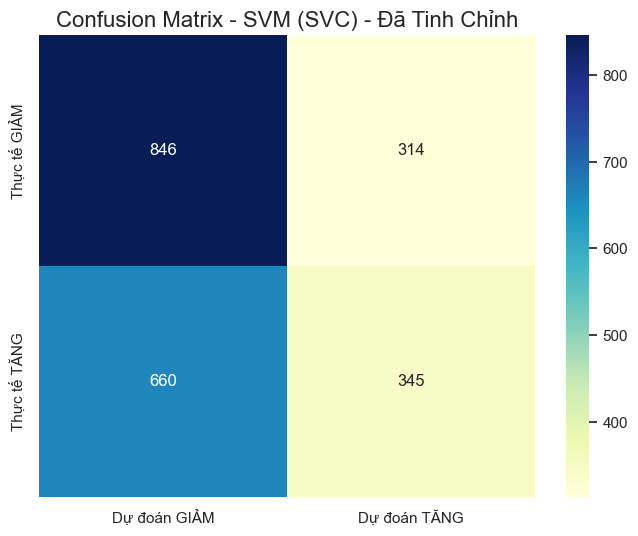

Đã lưu Confusion Matrix tại 'svm_confusion_matrix.png'

--- Đang vẽ đường cong ROC-AUC ---


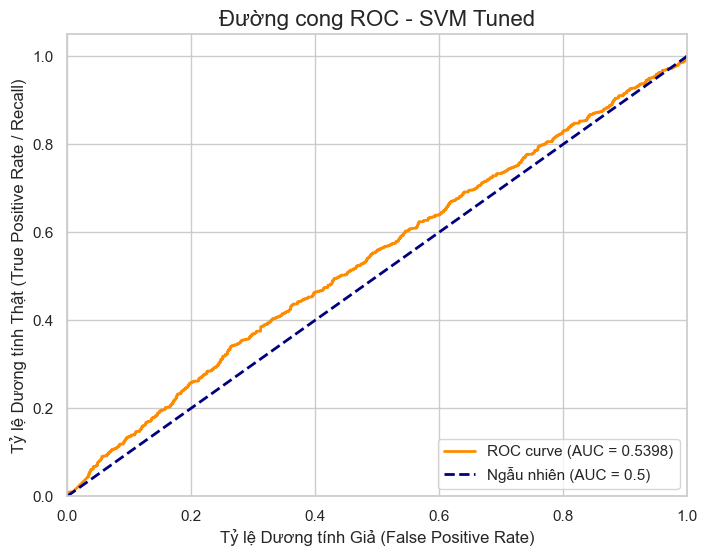

Đã lưu đường cong ROC-AUC tại 'svm_roc_curve.png' (AUC = 0.5398)

--- Đang gom file vào thư mục 'svm_model_results' ---

 TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'svm_model_results'


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit # Thêm Tuning
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import warnings
import os
import shutil
import time # Thêm để đo thời gian

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

def add_lag_and_interaction_features(df):
    """
    Hàm này thêm cả Đặc trưng Tương tác VÀ Đặc trưng Trễ.
    """
    # --- 1. Thêm Đặc trưng Tương tác ---
    print("--- Đang thêm Đặc trưng Tương tác ---")
    df['Price_vs_SMA'] = df['Price'] - df['SMA']
    df['Price_vs_ZLMA'] = df['Price'] - df['ZLMA']
    df['Bollinger_Width_Normalized'] = (df['Bollinger_Upper'] - df['Bollinger_Lower']) / df['SMA']

    # --- 2. Thêm Đặc trưng Trễ ---
    print("\n--- Đang thêm các Đặc trưng Trễ ---")
    features_to_lag = {
        'ZLMA': [1, 2], 'RSI': [1, 2], 'MACD_Hist': [1, 2],
        'Change %': [1, 2], 'Vol.': [1],
        'Price_vs_SMA': [1], 'Bollinger_Width_Normalized': [1]
    }
    for feature, lags in features_to_lag.items():
        if feature not in df.columns: continue
        for lag in lags:
            col_name = f"{feature}_lag_{lag}"
            df[col_name] = df.groupby('Ticker')[feature].shift(lag)
    return df

try:
    # 1. ĐỌC DỮ LIỆU 
    df = pd.read_csv('stock_data_with_indicators.csv') 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])

    # 2. CHUẨN BỊ DỮ LIỆU
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    df_with_features = add_lag_and_interaction_features(df)
    df_ml = df_with_features.dropna()

    # --- DANH SÁCH 28 FEATURES ---
    base_features = [
        'Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay','SMA',
        'Bollinger_Upper', 'Bollinger_Lower','RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'
    ]
    interaction_features = ['Price_vs_SMA', 'Price_vs_ZLMA', 'Bollinger_Width_Normalized']
    lag_features = [
        'ZLMA_lag_1', 'ZLMA_lag_2', 'RSI_lag_1', 'RSI_lag_2',
        'MACD_Hist_lag_1', 'MACD_Hist_lag_2', 'Change %_lag_1', 'Change %_lag_2',
        'Vol._lag_1', 'Price_vs_SMA_lag_1', 'Bollinger_Width_Normalized_lag_1'
    ]
    all_features = base_features + interaction_features + lag_features

    # 3. CHIA DỮ LIỆU (Dùng cách chia theo thời gian)
    print("\n--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---")
    train_data = df_ml[df_ml['Date'] < '2024-01-01']
    test_data = df_ml[df_ml['Date'] >= '2024-01-01']
    
    if train_data.empty or test_data.empty:
        print("Lỗi: Dữ liệu huấn luyện hoặc kiểm thử bị rỗng.")
    else:
        X_train = train_data[all_features]
        y_train = train_data['Target']
        X_test = test_data[all_features]
        y_test = test_data['Target']

        print(f"Tổng số features: {len(all_features)}")
        print(f"Mẫu huấn luyện: {len(X_train)}")
        print(f"Mẫu kiểm thử: {len(X_test)}")

        # CHUẨN HÓA DỮ LIỆU (BẮT BUỘC)
        print("\n--- Đang chuẩn hóa (Scaling) dữ liệu cho SVM ---")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 4. TINH CHỈNH THAM SỐ CHO SVM (SVC)
        print("\n--- Bắt đầu Tinh chỉnh Tham số cho SVM (SVC)... ---")
        start_tune_time = time.time()

        # 4.1 Định nghĩa "Menu" tham số C và gamma
        # Dùng thang log cho C và gamma vì chúng nhạy cảm theo cấp số nhân
        param_dist_svm = {
            'C': np.logspace(-2, 2, 10), # Thử C từ 0.01 đến 100 (10 giá trị)
            'gamma': np.logspace(-3, 1, 10) # Thử gamma từ 0.001 đến 10 (10 giá trị)
            # Bạn cũng có thể thêm 'gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 10))
        }

        # 4.2 Tạo mô hình SVC cơ sở
        model_base_svm = SVC(
            kernel='rbf', 
            class_weight='balanced', 
            random_state=42,
            probability=True # Giữ lại để có thể so sánh thời gian
        )
        
        # 4.3 Cài đặt TimeSeriesSplit
        tscv_svm = TimeSeriesSplit(n_splits=3) # Dùng 3 splits cho nhanh

        # 4.4 Cài đặt RandomizedSearchCV
        # n_iter=15: Thử 15 tổ hợp C, gamma ngẫu nhiên
        random_search_svm = RandomizedSearchCV(
            estimator=model_base_svm,
            param_distributions=param_dist_svm,
            n_iter=15, 
            scoring='accuracy',
            cv=tscv_svm,
            n_jobs=-1,
            random_state=42,
            verbose=1 # Hiển thị tiến trình
        )

        # 4.5 Chạy quá trình "dò" trên dữ liệu ĐÃ CHUẨN HÓA
        random_search_svm.fit(X_train_scaled, y_train) 
        
        end_tune_time = time.time()
        print(f"--- Tinh chỉnh SVM hoàn tất! (Thời gian: {((end_tune_time - start_tune_time) / 60):.2f} phút) ---")
        print(f"Bộ tham số C, gamma tốt nhất: {random_search_svm.best_params_}")
        print(f"Độ chính xác tốt nhất trên tập huấn luyện (cross-val): {random_search_svm.best_score_:.4f}")

        # 5. ĐÁNH GIÁ MÔ HÌNH SVM TỐT NHẤT
        best_svm_model = random_search_svm.best_estimator_
        
        # Dự đoán trên dữ liệu Test ĐÃ CHUẨN HÓA
        y_pred = best_svm_model.predict(X_test_scaled) 
        
        print("\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH SVM (SVC) - ĐÃ TINH CHỈNH ---")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy của SVM (SVC) - ĐÃ TINH CHỈNH: {accuracy:.4f}")
        
        report_text = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=4)
        print("\nBáo cáo Phân loại chi tiết:")
        print(report_text) 

        # 6. LƯU KẾT QUẢ
        output_folder = "svm_model_results"
        os.makedirs(output_folder, exist_ok=True) 
        
        report_filename = 'svm_report.txt' 
        cm_filename = 'svm_confusion_matrix.png'
        roc_filename = 'svm_roc_curve.png'

        # Lưu Báo cáo .txt
        with open(report_filename, "w", encoding="utf-8") as f:
            f.write(f"--- KẾT QUẢ SVM (SVC) - ĐÃ TINH CHỈNH (28 Features) ---\n")
            f.write(f"Tham số tốt nhất: {random_search_svm.best_params_}\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write(report_text)
        print(f"\nĐã lưu Báo cáo Phân loại tại '{report_filename}'")

        # Vẽ và lưu Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', # Đổi màu
                    xticklabels=['Dự đoán GIẢM', 'Dự đoán TĂNG'],
                    yticklabels=['Thực tế GIẢM', 'Thực tế TĂNG'])
        plt.title('Confusion Matrix - SVM (SVC) - Đã Tinh Chỉnh', fontsize=16)
        plt.savefig(cm_filename)
        plt.show() # HIỆN BIỂU ĐỒ
        plt.close()
        print(f"Đã lưu Confusion Matrix tại '{cm_filename}'")

        # VẼ ĐƯỜNG CONG ROC-AUC 
        print("\n--- Đang vẽ đường cong ROC-AUC ---")
        # Sử dụng y_test và y_pred_proba_svm đã tính ở trên
        y_proba = best_svm_model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})') # Hiển thị AUC
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ngẫu nhiên (AUC = 0.5)') # Đường tham chiếu
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tỷ lệ Dương tính Giả (False Positive Rate)')
        plt.ylabel('Tỷ lệ Dương tính Thật (True Positive Rate / Recall)')
        plt.title('Đường cong ROC - SVM Tuned', fontsize=16)
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig(roc_filename) # Lưu file ảnh ROC
        plt.show() # Hiển thị biểu đồ ROC
        plt.close()
        print(f"Đã lưu đường cong ROC-AUC tại '{roc_filename}' (AUC = {roc_auc:.4f})")

        # Gom file
        print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
        for fname in [report_filename, cm_filename, roc_filename]:
            if os.path.exists(fname):
                try:
                    shutil.move(fname, os.path.join(output_folder, fname))
                except Exception as e:
                    print(f"Lỗi khi di chuyển {fname}: {e}")

        print(f"\n TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
except ImportError:
    print ("\nLỗi: Thư viện chưa được cài đặt.")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")